In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from wordcloud import WordCloud, STOPWORDS
import jieba
import matplotlib.pyplot as plt


from urllib.parse import urljoin, urlparse

In [2]:
# initialize search parameters
first_search_term = 'Power BI Training Hong Kong'
search_url = "https://www.google.com/search?q=" + first_search_term
max_pages = 5
current_page = 1
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36'
parser = 'lxml'
keyword_list = []

In [3]:
def scrape(search_url, user_agent, parser, current_page):
    
    print(current_page, search_url)
    
    response = requests.get(search_url, headers={'User-Agent': user_agent})
    soup = BeautifulSoup(response.text, parser)
                         
    organic_div = soup.select('div.tF2Cxc')
    ads_div = soup.select('div.uEierd')
    keywords = soup.select('a div.s75CSd')
                         
    organic_df = parse_organic_div(organic_div)
    ads_df = parse_ads_div(ads_div)
                     
    organic_df['Type'] = 'Organic'
    ads_df['Type'] = 'Advertisement'
                         
    result_df = organic_df.append(ads_df)
    result_df['Keyword'] = search_url.split('=')[1]
    result_df['Page'] = current_page
    
    keyword_list = []
    for keyword in keywords:
        keyword_list.append(keyword.text)
    
    next_page = urljoin(base="https://www.google.com/", url=soup.select('td.d6cvqb a')[-1]['href'])
    print(next_page)
       
    return result_df, keyword_list, next_page, soup

In [4]:
# helper function for the scrape function
def parse_organic_div(divs):
    headings = []
    urls = []
    domains = []
    descriptions = []   
        
    for div in divs:
        headings.append(div.select('h3')[0].text)
        urls.append(div.select('div.yuRUbf a')[0]['href'])
        domains.append(div.select('div.yuRUbf a cite')[0].text.split(' ')[0])
        descriptions.append(div.select('div.IsZvec')[0].text)
    
    results_dict = {'Heading': headings, 'Domain': domains, 'URL': urls, 'Description': descriptions}
    
    return pd.DataFrame.from_dict(results_dict)

In [5]:
# helper function for the scrape function
def parse_ads_div(divs):
    ads_heading = []
    ads_desc = []
    ads_url = []
    ads_domain = []
    
    for ad in divs:
        ads_heading.append(ad.select('div.MUxGbd')[0].text)
        ads_desc.append(ad.select('div.MUxGbd')[1].text)
        ads_url.append(ad.select('div.d5oMvf a')[0]['href'])
        ads_domain.append(ad.select('div.d5oMvf a')[0]['data-pcu'])

    ads_dict = {'Heading': ads_heading, 'Domain': ads_domain, 'URL': ads_url, 'Description': ads_desc}
    
    return pd.DataFrame.from_dict(ads_dict)

In [6]:
# scrape first page
df_results, keywords, next_page, soup = scrape(search_url, user_agent, parser, current_page)

# scrape subsequent pages
for i in range(1, max_pages):
    df_tmp, keywords, next_page, soup = scrape(next_page, user_agent, parser, current_page + i)
    df_results = df_results.append(df_tmp)
    
# scrape related keywords
keywords_lvl2 = []
for kw in keywords:
    df_tmp, kw, next_page, soup = scrape("https://www.google.com/search?q=" + kw, user_agent, parser, 1)
    df_results = df_results.append(df_tmp)
    keywords_lvl2 += kw

# get company name from domain
df_results['Company'] = df_results['Domain'].apply(lambda x: max(urlparse(x).netloc.split('.'), key=len))


1 https://www.google.com/search?q=Power BI Training Hong Kong
https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=5os7YfOVGMOA1e8PyIGvyAg&start=10&sa=N&ved=2ahUKEwjzoNHb7fTyAhVDQPUHHcjAC4kQ8NMDegQIARBP
2 https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=5os7YfOVGMOA1e8PyIGvyAg&start=10&sa=N&ved=2ahUKEwjzoNHb7fTyAhVDQPUHHcjAC4kQ8NMDegQIARBP
https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=54s7Yez_IdbFhwOyjoigDQ&start=20&sa=N&ved=2ahUKEwisj5jc7fTyAhXW4mEKHTIHAtQ4ChDw0wN6BAgBEE8
3 https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=54s7Yez_IdbFhwOyjoigDQ&start=20&sa=N&ved=2ahUKEwisj5jc7fTyAhXW4mEKHTIHAtQ4ChDw0wN6BAgBEE8
https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=6Is7YfS-DsKDoAS0qqvwDA&start=30&sa=N&ved=2ahUKEwj00sHc7fTyAhXCAYgKHTTVCs44FBDw0wN6BAgBEE8
4 https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=6Is7YfS-DsKDoAS0qqvwDA&start=30&sa=N&ved=2ahUKEwj00sHc7fTyAhXCAYgKHTTVCs44FBDw0wN6BAgBEE8
https://www.google

In [7]:
keywords

['power bi課程免費',
 'Power BI course HK',
 'power query課程',
 'power bi證書',
 'power bi課程2021',
 'power bi香港',
 'Power BI 課程 2020',
 'Power BI 基礎']

In [8]:
df_results.to_excel('Scrape results - ' + first_search_term + '.xlsx')
df_results.head(3)

,Heading,Domain,URL,Description,Type,Keyword,Page,Company
0,Power BI培訓,https://www.nobleprog.hk,https://www.nobleprog.hk/zh-hant/power-bi-peixun,適合那些從未使用過PowerBI能夠創建合理的儀表板和報告的人。 Pernod Ricard...,Organic,Power BI Training Hong Kong,1,nobleprog
1,Microsoft Power BI Training in Hong Kong - The...,https://www.theknowledgeacademy.com,https://www.theknowledgeacademy.com/hk/courses...,Business Intelligence Reporting Training | Mic...,Organic,Power BI Training Hong Kong,1,theknowledgeacademy
2,PowerBI 商業智能分析證書課程,https://www.uec.edu.hk,https://www.uec.edu.hk/office_powerbi,Certificate in Microsoft Power BI for Business...,Organic,Power BI Training Hong Kong,1,www


In [9]:
keywords

['power bi課程免費',
 'Power BI course HK',
 'power query課程',
 'power bi證書',
 'power bi課程2021',
 'power bi香港',
 'Power BI 課程 2020',
 'Power BI 基礎']

<h3> Word Cloud

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\admin\AppData\Local\Temp\jieba.cache
Loading model cost 0.579 seconds.
Prefix dict has been built successfully.


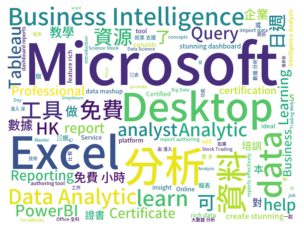

In [10]:
stop_words = list(STOPWORDS)

stop_words += first_search_term.split(' ')

stop_words += ['Course', 'Courses', 'Training', '課程', '香港']
stop_words += ['年', '月', '日', '週', '星期', '一天', '一個']
stop_words += ['是', '的', '不', '在', '和', '及', '與', '使用', '可以']
stop_words += ['能', '讓', '有', '我', '人', '你', '您', '上', '於', '但', '嗎', '為']
stop_words += ['一', '二', '三', '四', '五', '六', '七', '八', '九', '十']

font_path = 'NotoSansTC-Medium.otf'

wc = WordCloud(font_path=font_path, background_color="white", width=1024, height=768, 
               max_words=100, max_font_size=200, stopwords=stop_words)

text_list = jieba.cut(" ".join(df_results['Description'].to_list()))
wc.generate(" ".join(text_list))

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

plt.savefig('Word Cloud - ' + first_search_term + '.jpg', bbox_inches='tight')

plt.show()

In [11]:
keywords_lvl2[-10:]

['power bi證書',
 'Power BI教程',
 'power bi教學pdf',
 'power bi教學書',
 'power bi自學',
 'power bi是什麼',
 'power bi教學範例',
 'power bi安裝',
 'power bi免費',
 'power bi網頁版']

<h3> Graphs

In [12]:
import seaborn as sns

In [13]:
df = pd.read_excel(r'Scrape results - Power BI Training Hong Kong.xlsx')

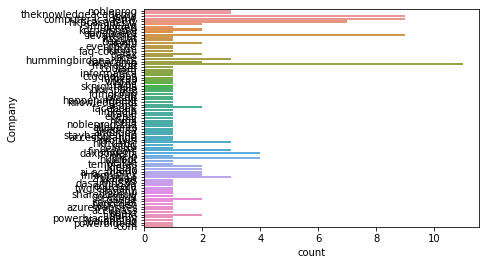

In [14]:
ax = sns.countplot(y="Company", data=df)

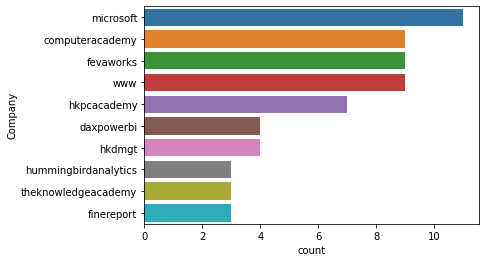

In [15]:
ax = sns.countplot(y="Company", data=df, 
                   order=df.Company.value_counts().iloc[:10].index)

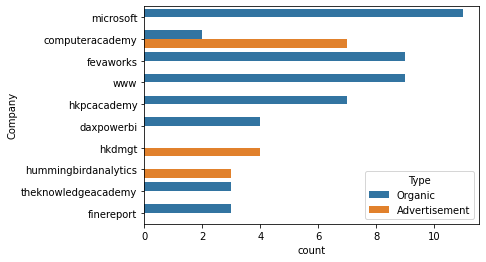

In [16]:
ax = sns.countplot(y="Company", hue="Type", data=df, order=df.Company.value_counts().iloc[:10].index)

In [17]:
len(df)

151

In [18]:
df.drop_duplicates(subset=['Heading', 'Domain'], inplace=True)

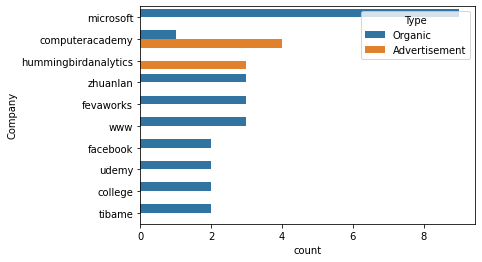

In [19]:
ax = sns.countplot(y="Company", hue="Type", data=df,
                   order=df.Company.value_counts().iloc[:10].index)

In [20]:
df['Type'].value_counts()

Organic          94
Advertisement    15
Name: Type, dtype: int64

<AxesSubplot:ylabel='Type'>

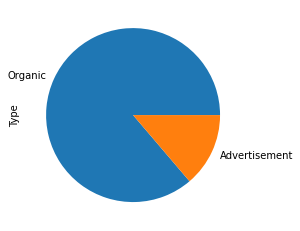

In [21]:
df['Type'].value_counts().plot.pie()

<AxesSubplot:ylabel='Company'>

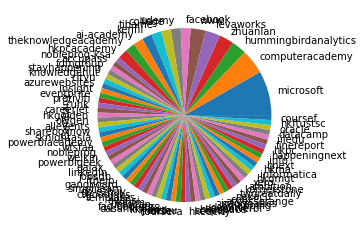

In [22]:
df['Company'].value_counts().plot.pie()

In [23]:
df.Company.value_counts().iloc[:10]

microsoft               9
computeracademy         5
hummingbirdanalytics    3
zhuanlan                3
fevaworks               3
www                     3
facebook                2
udemy                   2
college                 2
tibame                  2
Name: Company, dtype: int64